# Detecting malicious URLs

In [15]:
# GENERAL
import os
import math
import re
import datetime
import time
import pandas as pd
import matplotlib as plt
import seaborn as sns
from tqdm import tqdm

For this experiment, we will be using the Sklearn and Fast.ai libraries to assist us across the data science process.

In [129]:
# SKLEARN
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, f1_score ,recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [17]:
# Fast.ai
from fastai.tabular import *
# from fastai.column_data import *

In [18]:
# Models
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

Here we import some libraries to assist us in pulling, parsing, and transforming our domain information.

In [19]:
# DOMAIN SPECIFIC LIBRARIES
import tldextract
from datetime import datetime
import warnings
from urllib.parse import urlparse
from socket import gethostbyname, gaierror, timeout
import whois
import socket

In [20]:
# iPython and Notebook config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #display all results

%config InlineBackend.figure_format = 'retina' #see plots in retina displays
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Data Ingestion

### The bad stuff

Exploring the Internet, we find a nice list of maliciousness, provided by http://www.malwaredomainlist.com/

Link: http://www.malwaredomainlist.com/hostslist/hosts.txt

In [5]:
# Ingest malicious urls from malwaredomainlist
columns = ['ip', 'url']

mal_df = pd.read_csv('../data/hosts.txt', 
                     delimiter = '\s+', 
                     encoding = "ISO-8859-1", 
                     skiprows=6,
                     names = columns)[['url']]

In [ ]:
# Randomly sample 500 elements from your dataframe
mal_sample_df = mal_df.sample(n=1500)

In [25]:
mal_sample_df = pd.read_csv("malicious_1000.csv", index_col=0)
mal_sample_df.head()

,url,class,domain_creation,domain_update,host_ip,specials,domain,suffix,domain_name,prefix,entropy
977,www.infra.by,malicious,2019-07-12 16:59:28,2019-07-12 17:55:31,91.149.157.185,2,infra,by,infra.by,91,3.022055
997,www.northpoleitalia.it,malicious,2018-08-29 12:02:06,2018-08-29 12:06:08,165.231.200.49,2,northpoleitalia,it,northpoleitalia.it,165,3.447402
452,nowina.info,malicious,2003-11-07 10:58:16,2018-10-24 08:42:08,185.18.29.3,1,nowina,info,nowina.info,185,2.663533
1087,xorgwebs.webs.com,malicious,1995-04-04 04:00:00,2017-03-03 17:11:11,104.17.119.40,2,webs,com,webs.com,104,3.381580
74,beautysafari.com,malicious,2019-04-26 18:51:18,2019-04-26 18:51:27,23.20.239.12,1,beautysafari,com,beautysafari.com,23,3.702820


In [ ]:
mal_sample_df['class'] = 'malicious'

In [ ]:
mal_sample_df.head()

### The mostly benign stuff

In [ ]:
# Ingest Alex top 1 million urls 
columns = ['url']

benign_df = pd.read_csv('../data/top-1m.csv', 
                     encoding = "ISO-8859-1", 
                     names = columns)

In [ ]:
benign_sample_df = benign_df.iloc[0:2500]

In [ ]:
benign_sample_df['class'] = 'benign'

In [26]:
benign_sample_df = pd.read_csv("benign_1000.csv", index_col=0)

In [27]:
benign_sample_df.head()

,url,class,domain_creation,domain_update,host_ip,specials,domain,suffix,domain_name,prefix,entropy
1,google.com,benign,1997-09-15 04:00:00.000,2018-02-21 18:36:40.000,216.58.196.142,1,google,com,google.com,216,2.646439
2,youtube.com,benign,2005-02-15 05:13:12.000,2019-01-14 10:32:15.000,216.58.200.110,1,youtube,com,youtube.com,216,3.095795
3,baidu.com,benign,1999-10-11 11:05:17.000,2019-05-09 04:30:46.000,123.125.114.144,1,baidu,com,baidu.com,123,3.169925
4,facebook.com,benign,1997-03-29 05:00:00.000,2018-07-23 18:17:13.000,157.240.8.35,1,facebook,com,facebook.com,157,3.022055
5,qq.com,benign,1995-05-04 04:00:00.000,2019-07-11 03:13:45.000,111.161.64.40,1,qq,com,qq.com,111,2.251629


### Data Enrichment

In [42]:
# Ingest IANA dataset
iana = pd.read_csv("https://www.iana.org/assignments/ipv4-address-space/ipv4-address-space.csv", sep=",")
iana.columns = iana.columns.str.strip().str.lower()
iana.rename(columns={'Prefix': 'prefix'}, inplace=True)

# Clean up prefix since it uses old/BSD formatting
iana['prefix']= iana['prefix'].apply(lambda x: re.sub('^(00|0)','',x))
iana['prefix'] = iana['prefix'].apply(lambda x: re.sub('/8$','',x))
iana['prefix'] = pd.to_numeric(iana['prefix'], downcast='float', errors='ignore').astype(int).astype(str)

iana.head()

,prefix,designation,date,whois,rdap,status [1],note
0,0,IANA - Local Identification,1981-09,NaN,NaN,RESERVED,[2]
1,1,APNIC,2010-01,whois.apnic.net,https://rdap.apnic.net/,ALLOCATED,NaN
2,2,RIPE NCC,2009-09,whois.ripe.net,https://rdap.db.ripe.net/,ALLOCATED,NaN
3,3,Administered by ARIN,1994-05,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN
4,4,"Level 3 Parent, LLC",1992-12,whois.arin.net,https://rdap.arin.net/registry\nhttp://rdap.ar...,LEGACY,NaN


In [28]:
# Frames we would like to merge
full_data = [mal_sample_df, benign_sample_df]
print(mal_sample_df.shape, benign_sample_df.shape)

(1000, 11) (1000, 11)


In [ ]:
tqdm.pandas()

def creation_date(domain_name):
    """
    Gets creation date of domain from whois
    """
    
    # Get creation date of Domain
    currentDT = datetime.now()
    default_date = currentDT.strftime("%Y-%m-%d %H:%M:%S")
    
    try:
        creation_date = whois.whois(domain_name).creation_date
        if type(creation_date) is list:
            return creation_date[0]
#         elif str(creation_date).find('Aug'):
#             creation_date = "1996-07-01 00:00:01"
#             return creation_date
        elif creation_date == None:
            return default_date
        else:
            return creation_date
    except whois.parser.PywhoisError:
        return default_date
    except gaierror:
        return default_date
    except socket.timeout:
        return default_date
    except socket.error:
        return default_date

# Generate creation date
for df in full_data:
    df['domain_creation'] = df['url'].progress_apply(lambda x: creation_date(x))

In [ ]:
tqdm.pandas()

def last_update_date(domain_name):
    """
    Gets creation date of domain from whois
    """
    
    # Get creation date of Domain
    currentDT = datetime.now()
    default_date = currentDT.strftime("%Y-%m-%d %H:%M:%S")
    
    try:
        last_updated = whois.whois(domain_name).updated_date
        if type(last_updated) is list:
            return last_updated[0]
        elif last_updated == None:
            return default_date
        else:
            return last_updated
    except whois.parser.PywhoisError:
        return default_date
    except gaierror:
        return default_date
    except socket.timeout:
        return default_date
    except socket.error:
        return default_date

# Generate creation date
for df in full_data:
    df['domain_update'] = df['url'].progress_apply(lambda x: last_update_date(x))

In [ ]:
def host_ip(domain):
    """
    Gets Host IP of Domain
    """

    # Get HOST IP     
    try:
        host = gethostbyname(domain)
        return host
    except gaierror:
        return 'missing'

# Generate host ip
for df in full_data:
    df['host_ip'] = df['url'].apply(lambda x: host_ip(x))

In [ ]:
# Generate number of special characters
for df in full_data:
    df['specials'] = df['url'].apply(lambda x: len(re.sub('[\w]+' ,'', x)))

In [ ]:
# Get domain
for df in full_data:
    df['domain'] = df['url'].apply(lambda x: tldextract.extract(x).domain)    

In [ ]:
# Get URL suffix
for df in full_data:
    df['suffix'] = df['url'].apply(lambda x: tldextract.extract(x).suffix)

In [ ]:
# Generate domain name
for df in full_data:
    df['domain_name'] = df['url'].apply(lambda x: tldextract.extract(x).registered_domain)

In [ ]:
# Get IP first octet
for df in full_data:
    df['prefix'] = df['host_ip'].str.extract('(\d+)\.').astype(int, errors='ignore').astype(str)
    df['prefix'] = df['prefix'].fillna('missing')
    df['prefix'] = df['prefix'].replace('nan', 'missing')

In [ ]:
def entropy(string):
    """
    Calculates the Shannon entropy of a string
    """

    # Get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # Calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return entropy

# Calculate entropy
for df in full_data:
    df['entropy'] = df['url'].apply(lambda x: entropy(str(x)))

In [ ]:


# Clean up prefix since it uses old/BSD formatting
iana['prefix']= iana['prefix'].apply(lambda x: re.sub('^(00|0)','',x))
iana['prefix'] = iana['prefix'].apply(lambda x: re.sub('/8$','',x))
iana['prefix'] = pd.to_numeric(iana['prefix'], downcast='float',errors='ignore').astype(str)

# Calculate entropy
for df in full_data:
    df['entropy'] = df['url'].apply(lambda x: entropy(str(x)))

In [ ]:
benign_sample_df['domain_creation'] = pd.to_datetime(benign_sample_df['domain_creation'], errors='coerce')
benign_sample_df['domain_creation'].groupby([benign_sample_df["domain_creation"].dt.year, benign_sample_df["domain_creation"].dt.month]).count().plot(kind="bar")

In [ ]:
mal_sample_df['domain_creation'] = pd.to_datetime(mal_sample_df['domain_creation'], errors='coerce')
mal_sample_df['domain_creation'].groupby([mal_sample_df["domain_creation"].dt.year, mal_sample_df["domain_creation"].dt.month]).count().plot(kind="bar")

In [ ]:
mal_sample_df['domain_update'] = pd.to_datetime(mal_sample_df['domain_update'], errors='coerce')
mal_sample_df['domain_update'].groupby([mal_sample_df["domain_update"].dt.year, mal_sample_df["domain_update"].dt.month]).count().plot(kind="bar")

In [ ]:
benign_sample_df['domain_update'] = pd.to_datetime(benign_sample_df['domain_update'], errors='coerce')
benign_sample_df['domain_update'].groupby([benign_sample_df["domain_update"].dt.year, benign_sample_df["domain_update"].dt.month]).count().plot(kind="bar")

In [ ]:
benign_sample_df.to_csv("benign_2500.csv")

In [ ]:
mal_sample_df.to_csv("malicious_2500.csv")

In [72]:
# Calculate digits percentage
df['number_digits'] = df['url'].str.count('[0-9]')
df['string_length'] = df['url'].str.len()
df['digits_percentage'] = (df['number_digits']/df['string_length'])*100

In [73]:
# Cast domain age columnt to datetime
df['domain_creation'] = pd.to_datetime(df['domain_creation'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Calculate the age of the domain
df['days_old'] = pd.datetime.today().date() - df['domain_creation'].dt.date

# Cast age to an integer
df['days_old'] = df['days_old'].astype(str).str.extract("(\d+)")

In [74]:
# Cast domain age columnt to datetime
df['domain_update'] = pd.to_datetime(df['domain_update'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Calculate the age of the domain
df['days_since_update'] = pd.datetime.today().date() - df['domain_update'].dt.date

# Cast age to an integer
df['days_since_update'] = df['days_since_update'].astype(str).str.extract("(\d+)")

In [71]:
df = pd.concat(full_data).reset_index(drop=True)
idx = np.random.permutation(df.index)
df = df.reindex(idx)
df

,url,class,domain_creation,domain_update,host_ip,specials,domain,suffix,domain_name,prefix,entropy
1328,patreon.com,benign,2013-02-27 05:48:01.000,2018-11-01 16:51:52.000,104.16.6.49,1,patreon,com,patreon.com,104,3.277613
179,1866809.securefastserver.com,malicious,2010-11-01 10:03:36,2016-11-21 00:28:04,missing,2,securefastserver,com,securefastserver.com,missing,3.896292
1184,gamepedia.com,benign,1999-06-01 21:12:07.000,2019-07-12 18:33:07.000,104.17.95.92,1,gamepedia,com,gamepedia.com,104,3.238901
1229,bitly.com,benign,2003-11-12 02:28:26.000,2018-04-12 16:49:39.000,67.199.248.14,1,bitly,com,bitly.com,67,3.169925
381,tube8vidslmf.dnset.com,malicious,2005-11-21 19:25:29,2018-09-17 07:01:09,103.31.186.29,2,dnset,com,dnset.com,103,3.913977
1384,ctrip.com,benign,1999-08-09 00:30:46.000,2016-02-05 03:46:44.000,140.207.228.16,1,ctrip,com,ctrip.com,140,2.947703
1131,youku.com,benign,2003-12-22 09:57:45.000,2019-03-01 05:38:31.000,106.11.47.19,1,youku,com,youku.com,106,2.725481
1628,marriott.com,benign,1993-01-05 05:00:00.000,2018-12-31 06:43:36.000,104.84.8.218,1,marriott,com,marriott.com,104,2.918296
1699,rakuten.com,benign,1997-09-12 04:00:00.000,2018-08-10 09:11:21.000,203.190.58.50,1,rakuten,com,rakuten.com,203,3.459432
1596,gov.ao,benign,2019-07-12 17:44:20.000,2019-07-12 18:41:02.000,154.116.255.20,1,gov,ao,gov.ao,154,2.251629


In [75]:
df = df.merge(iana[['prefix', 'designation']], how='inner', on='prefix')

In [76]:
df.head(100)

,url,class,domain_creation,domain_update,host_ip,specials,domain,suffix,domain_name,prefix,entropy,number_digits,string_length,digits_percentage,days_old,days_since_update,designation
0,patreon.com,benign,2013-02-27 05:48:01,2018-11-01 16:51:52,104.16.6.49,1,patreon,com,patreon.com,104,3.277613,0,11,0.000000,2327,254,ARIN
1,gamepedia.com,benign,1999-06-01 21:12:07,2019-07-12 18:33:07,104.17.95.92,1,gamepedia,com,gamepedia.com,104,3.238901,0,13,0.000000,7347,1,ARIN
2,marriott.com,benign,1993-01-05 05:00:00,2018-12-31 06:43:36,104.84.8.218,1,marriott,com,marriott.com,104,2.918296,0,12,0.000000,9685,194,ARIN
3,fiverr.com,benign,2009-12-08 20:58:25,2014-02-04 17:39:30,104.18.254.23,1,fiverr,com,fiverr.com,104,3.121928,0,10,0.000000,3504,1985,ARIN
4,luckyclean.info,malicious,2018-12-09 09:35:28,2019-02-07 20:30:27,104.24.125.140,1,luckyclean,info,luckyclean.info,104,3.506891,0,15,0.000000,216,156,ARIN
5,avgle.com,benign,2016-11-28 08:25:06,2019-07-12 18:43:55,104.27.154.26,1,avgle,com,avgle.com,104,3.169925,0,9,0.000000,957,1,ARIN
6,hesport.com,benign,2007-11-08 08:43:43,2018-10-19 13:12:02,104.25.91.17,1,hesport,com,hesport.com,104,3.277613,0,11,0.000000,4265,267,ARIN
7,urdupoint.com,benign,2000-05-02 20:13:49,2019-02-28 07:27:56,104.17.14.38,1,urdupoint,com,urdupoint.com,104,3.392747,0,13,0.000000,7011,135,ARIN
8,zara.com,benign,1997-05-29 04:00:00,2016-05-02 10:24:15,104.70.191.43,1,zara,com,zara.com,104,2.750000,0,8,0.000000,8080,1167,ARIN
9,creditkarma.com,benign,2005-08-30 02:56:23,2019-04-15 21:04:38,104.85.210.194,1,creditkarma,com,creditkarma.com,104,3.373557,0,15,0.000000,5065,89,ARIN


In [81]:
procs = [FillMissing, Categorify, Normalize]

In [78]:
drops = ['url', 'host_ip', 'domain', 'domain_name', 'domain_creation', 'domain_update']
sample_df = df.drop(drops, axis=1)

In [83]:
sample_df['days_old'] = pd.to_numeric(sample_df['days_old'], errors='coerce')
sample_df['days_since_update'] = pd.to_numeric(sample_df['days_since_update'], errors='coerce')

In [79]:
valid_idx = range(len(sample_df)-400, len(sample_df))
dep_var = 'class'
cat_names = ['suffix', 'prefix', 'designation']

In [84]:
data = TabularDataBunch.from_df(path, sample_df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names) 

['string_length', 'specials', 'entropy', 'digits_percentage', 'days_old', 'days_since_update', 'number_digits']


In [85]:
print(data.train_ds.cont_names)

['string_length', 'specials', 'entropy', 'digits_percentage', 'days_old', 'days_since_update', 'number_digits']


In [112]:
learn = tabular_learner(data, layers=[200,200], metrics=accuracy)
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.535815,0.655881,0.732500,00:00
1,0.425394,0.490136,0.825000,00:00
2,0.351744,0.384502,0.842500,00:00
3,0.302450,0.381964,0.840000,00:00
4,0.268439,0.386558,0.832500,00:00


In [113]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

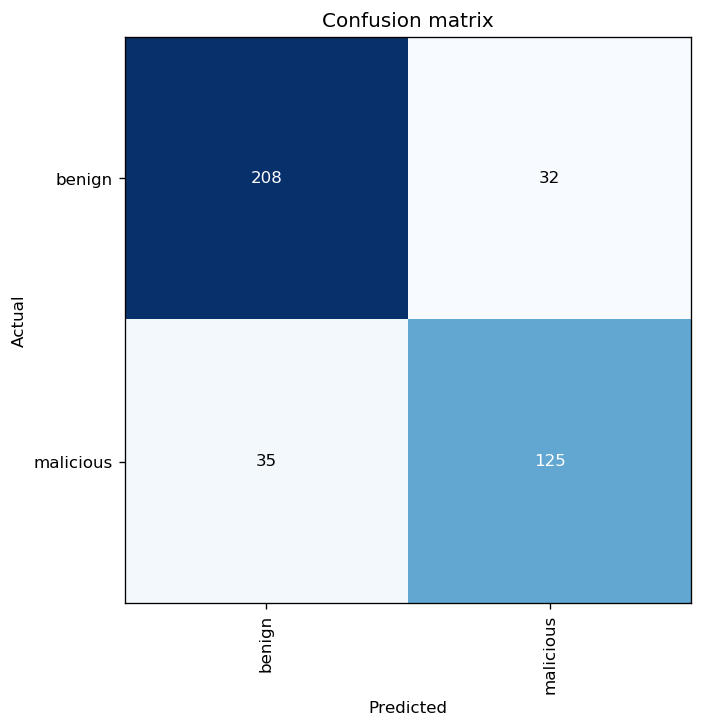

In [114]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [132]:
def get_proc_df(tll):
    """Get processed xs and ys from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    
    # Reconstruct ys to apply log if specified
    y_vals = np.array([i.obj for i in tll.y])
    return x_df, y_vals

X, y = get_proc_df(data)

# Label target
target_le = LabelEncoder()
y = target_le.fit_transform(y)

In [135]:
# Validation set
x_vals = np.concatenate([data.valid_dl.x.codes, data.valid_dl.x.conts], axis=1)
x_cols = data.valid_dl.x.cat_names + data.valid_dl.x.cont_names

X_valid = pd.DataFrame(data=x_vals, columns=x_cols)[
    [c for c in data.inner_df.columns if c in x_cols] ] # Retain order

# Reconstruct ys to apply log if specified
y_valid = np.array([i.obj for i in data.valid_dl.y])

# Label target
target_le = LabelEncoder()
y_valid = target_le.fit_transform(y_valid)

In [116]:
data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x1a2ddb7e10>, device=device(type='cpu'), tfms=[], collate_fn=<function data_collate at 0x1a25a67048>)

  * Initiating Malicious URL Model
  * Training Malicious URL Model


/Users/alistairgillespie/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


  * Predicting test classes



  * Performance testing:
    Precision - 0.876
    Recall - 0.662
    F1 - 0.754

Confusion matrix:
 [[225  15]
 [ 54 106]]


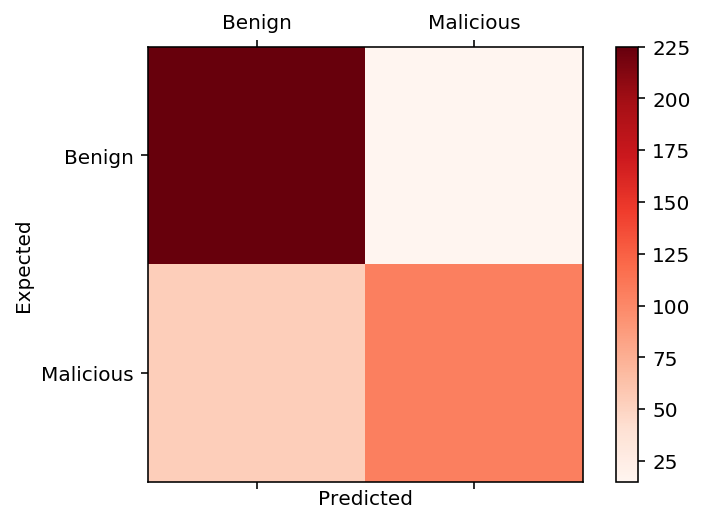

In [136]:
# Parameters for Grid Search
param_grid = {
    'min_samples_split': [3, 5, 10], 
    'max_depth': [3, 5],
    'max_features': [3, 4, 6]
}

# Scoring for Grid Search
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

clf = RandomForestClassifier(
        criterion='entropy',
        n_estimators=300)

# Setup base Classifier and Grid Search
print('  * Initiating Malicious URL Model') 
rdf = GridSearchCV(clf, param_grid, scoring=scorers, refit='recall_score',
                   return_train_score=True, n_jobs=4)

# Fit model
print('  * Training Malicious URL Model') 
rdf.fit(X, y);

# Run predictions
print('  * Predicting test classes')     
rfprediction = rdf.predict(X_valid)  # predict output

# Calculate accuracy 
print('\n\n')
print('  * Performance testing:')
print("    Precision - %1.3f" % precision_score(y_valid, rfprediction))
print("    Recall - %1.3f" % recall_score(y_valid, rfprediction))
print("    F1 - %1.3f\n" % f1_score(y_valid, rfprediction))

# Confusion matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=rfprediction)
print('Confusion matrix:\n', conf_mat)

labels = ['Benign', 'Malicious']
fig = plt.figure();
ax = fig.add_subplot(111);
cax = ax.matshow(conf_mat, cmap=plt.cm.Reds);
fig.colorbar(cax);
ax.set_xticklabels([''] + labels);
ax.set_yticklabels([''] + labels);
plt.xlabel('Predicted');
plt.ylabel('Expected');

plt.show();

In [138]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, rfprediction)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8